## Main Training Script

### Preparation

Here, the necessary libraries are loaded and the GPU is set for training. As some of the code runs with previous versions of the libraries, we include switching off the warnings in this example code. You can omit this, when running your experiments to understand the behavior of you script better.

In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
import fastai
from fastai.vision import *
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import datetime
from path import Path
from PIL import Image, ImageFile
import sklearn.utils.class_weight as cw

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
gpu_device_number = 0
torch.cuda.set_device(gpu_device_number)
print("This experiments runs on your " 
      + torch.cuda.get_device_name(device=gpu_device_number))

This experiments runs on your TITAN RTX


All experimental data are stored in a Results folder in your working directory. This includes the weights of the trained model, the graphs from the learning rate finder, a chart of the accuracy / loss during training, and the results dataframe (see below).

In [57]:
os.getcwd()
saving_path = os.getcwd() + "/Results/"
saving_path = os.path.dirname(saving_path)
if not os.path.exists(saving_path):
    os.makedirs(saving_path)

The ```path_``` variable gives the directory where your image tiles are located. You can download the example tiles and recreate the experiment done in this notebook.

In [58]:
path_ = "path/to/the/Example_Tiles"

The key.csv file is a list of your images to gether with the patient IDs, the labels, and information on which set (TRAIN, VALID, TEST) the respective patient was randomized to. You can find an example key.csv file for the example tiles in this Github repository.

In [29]:
df = pd.read_csv(os.getcwd() + "/key.csv", sep=',')
mod_df = df[["Path", "Label", "training_set", "is_valid"]]
mod_df

,Path,Label,training_set,is_valid
0,DDLPS_1_TRAIN_01.jpg,DDLPS,TRAIN,False
1,DDLPS_1_TRAIN_02.jpg,DDLPS,TRAIN,False
2,DDLPS_1_TRAIN_03.jpg,DDLPS,TRAIN,False
3,DDLPS_1_TRAIN_04.jpg,DDLPS,TRAIN,False
4,DDLPS_1_TRAIN_05.jpg,DDLPS,TRAIN,False
...,...,...,...,...
70,UPS_2_VALID_01.jpg,UPS,VALID,True
71,UPS_2_VALID_02.jpg,UPS,VALID,True
72,UPS_2_VALID_03.jpg,UPS,VALID,True
73,UPS_2_VALID_04.jpg,UPS,VALID,True


Here, the image augmentations are defined. Progressive sprinkles are realized using the ```cutout``` functionality. Alternatively, you can use the implementation found here https://github.com/jcgy/sprinkles and also find additional information on progressive sprinkles, cutouts, mixup, etc.

In [30]:
tfms = get_transforms(flip_vert=True,                 
                      max_rotate=90.0,                
                      max_lighting=0.3,
                      xtra_tfms=[#sprink(p=1.),
                                 cutout(n_holes=(60,80), 
                                 length=(8, 8), p=1.), 
                                 contrast(scale=(0.5, 2.), p=1.), 
                                 #jitter(magnitude=0.005, p=.1), 
                                 brightness(change=(0.4), p=1.)])

The ```def get_file``` and ```def examples``` are used to inspect, what the augmentation process does and whether the transformations are useful. You can apply this to one of the example tiles in the respective folder.

In [31]:
def get_file(): return open_image("/Example_Tiles/DDLPS_1_TRAIN_01.jpg")

In [32]:
def examples(rows, cols, width, height, **kwargs):
    [get_file().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

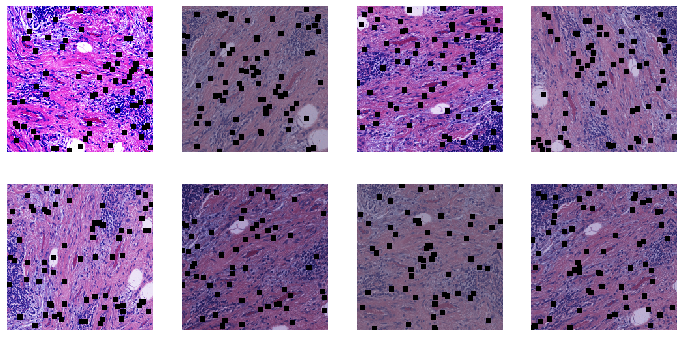

In [33]:
examples(2, 4, 12, 6, size=224)

Now the dataloader is defined. Here you can also include a test set, define the batch size, use custom normalization values, etc. It is important not to use the ```.split_by_rand_pct``` functionality ans this would make a tile level split, rather than a patient level split. This is why the ```mod_df``` has an is_valid column.

In [34]:
data = (vision.ImageList.from_df(mod_df, path_)
         #.split_by_rand_pct(0.2)
         .split_from_df(col='is_valid')
         .label_from_df(cols='Label')
         #.add_test(test_data)
         .transform(tfms, size=(1024, 1024))
         .databunch(bs=5, val_bs=5, num_workers=16)
         .normalize(vision.imagenet_stats))

Here you can find out whether your data set is balanced and make changes to the class weights. This is useful if you have a dominant class which you want to account for.

In [35]:
classweights = torch.FloatTensor(cw.compute_class_weight('balanced', np.unique(data.train_ds.y.items), data.train_ds.y.items)).cuda()
print(classweights)

tensor([1., 1., 1., 1., 1.], device='cuda:0')


In [36]:
#classweights[1] = 1.2 Insert different class weight here

### Training

Now the learner, the model logger, and the callbacks are defined. This can be adjusted to your individial needs.

In [37]:
learn = vision.cnn_learner(data, 
                           vision.models.densenet121, 
                           metrics=[fastai.metrics.accuracy, fastai.metrics.error_rate], 
                           path=saving_path,
                           loss_func=nn.CrossEntropyLoss(weight=classweights),
                           model_dir='Models')

In [38]:
Run_part = 0
Modelname = "Best_Model_" + str(Durchgang)

model_logger = fastai.callbacks.CSVLogger(learn, 
                                          filename="Training",
                                          append=True)

def save_model(Durchgang, learn):
    Modelname = "Best_Model_" + str(Durchgang)
    save_model = fastai.callbacks.SaveModelCallback(learn, 
                                                every="improvement", 
                                                monitor="accuracy", 
                                                name=Modelname)
    return save_model

mixup = fastai.callbacks.MixUpCallback(learn)

In [39]:
Run_part = 1

The ```lr_find``` functionality can give you a first indication of where your optimal learning rate can be.

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 8.32E-03


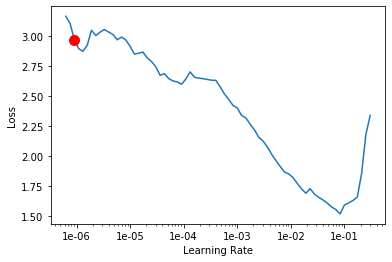

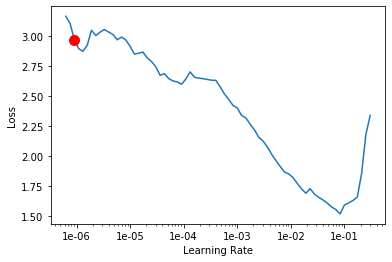

In [41]:
learn.recorder.plot(suggestion=True, return_fig=True)

To get an even better understanding of the optimal learning rate, we repeat this process three times and take the average learning rate from these repeats. Usually this will be close to 0.0001 for our experminents so we fix the learning rate at 0.0001 to make the results more comparable.

In [42]:
#lr_avg = 0
#for i in range(3):
#    learn.lr_find()
#    img = learn.recorder.plot(suggestion=True, return_fig=True)
#    plt.savefig(saving_path + '/First_LRF_' + str(i) + '.png')
#    plt.close()
#    lr_avg += learn.recorder.min_grad_lr
#lr_avg /= 3
#print('Avarage Learningrate: {}'.format(lr_avg))

In [43]:
lr_avg = 0.0001

In [44]:
learn.fit_one_cycle(25,
                    lr_avg, 
                    callbacks=[save_model(Run_part, learn), model_logger], 
                    wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.910974,2.186847,0.200000,0.800000,02:36
1,2.752238,2.169438,0.080000,0.920000,02:35
2,2.883071,2.082014,0.160000,0.840000,02:34
3,2.648034,2.188269,0.160000,0.840000,02:36
4,2.377020,2.152829,0.240000,0.760000,02:44
5,2.202974,2.064152,0.360000,0.640000,02:43
6,2.025126,1.983110,0.520000,0.480000,02:45
7,1.863708,2.065892,0.440000,0.560000,02:44
8,1.698382,1.831932,0.440000,0.560000,02:47
9,1.595408,2.040977,0.440000,0.560000,02:47


Better model found at epoch 0 with accuracy value: 0.20000000298023224.
Better model found at epoch 4 with accuracy value: 0.23999999463558197.
Better model found at epoch 5 with accuracy value: 0.36000001430511475.
Better model found at epoch 6 with accuracy value: 0.5199999809265137.
Better model found at epoch 18 with accuracy value: 0.5600000023841858.
Better model found at epoch 24 with accuracy value: 0.6000000238418579.


In this variation of the code, we stop after 25 epochs and re-adjust the learning rate as a split learning rate and also unfreeze the weights of the whole networks for the last 25 epochs of the overall 50 epochs of training. This will usually lead to a further improvement of the training and validation accuracy. We also export the model multiple times to make sure to have everything backed up.

In [45]:
learn.load(saving_path + "/Models/Best_Model_" + str(Run_part))
learn.export(saving_path + "\\" + "Model_after_" + str(Run_part)+"_Stage.pkl")

In [46]:
Run_part = 2

In [47]:
lr_avg_2 = 0
for i in range(3):
    learn.lr_find()
    img = learn.recorder.plot(suggestion=True, return_fig=True)
    plt.savefig(saving_path + '/Second_LRF_' + str(i) + '.png')
    plt.close()
    lr_avg_2 += learn.recorder.min_grad_lr
lr_avg_2 /= 3
print('Avarage Learningrate: {}'.format(lr_avg_2))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.58E-03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.63E-04
Avarage Learningrate: 3.286868631620937e-06


In [48]:
learn.unfreeze()
learn.fit_one_cycle(25, 
                    slice(lr_avg_2, lr_avg), 
                    callbacks=[save_model(Run_part, learn), model_logger], 
                    wd=0.1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.655821,2.468321,0.520000,0.480000,02:46
1,0.509804,2.721452,0.480000,0.520000,02:36
2,0.555878,2.626208,0.520000,0.480000,02:35
3,0.630336,2.129947,0.560000,0.440000,02:37
4,0.615395,2.286645,0.480000,0.520000,02:35
5,0.568819,2.320496,0.560000,0.440000,02:35
6,0.547084,2.652356,0.480000,0.520000,02:38
7,0.517645,2.475736,0.480000,0.520000,02:35
8,0.557899,3.050897,0.400000,0.600000,02:35
9,0.511400,2.917590,0.400000,0.600000,02:37


Better model found at epoch 0 with accuracy value: 0.5199999809265137.
Better model found at epoch 3 with accuracy value: 0.5600000023841858.


In [49]:
learn.load(saving_path + "/Models/Best_Model_" + str(Run_part))
learn.export(saving_path + "\\" + "Model_after_" + str(Run_part)+"_Stage.pkl")

### Evaluation

After training of 50 epochs the best model is reloaded for the export of the validation predictions and evaluation of the model. Here you can use either the built-in fast.ai functionalities or write your own evaluation scripts.

In [ ]:
Run_part = 1
learn.load(saving_path + "/Models/Best_Model_" + str(Run_part))

In [51]:
preds = learn.get_preds()

In [52]:
class_dict = learn.data.c2i
keys = ['Patient_ID', 'Label', 'Prediction'] + [k for k in class_dict.keys()]
valid = df.groupby('training_set').get_group('VALID').reset_index(drop=True)
valid.rename(columns={'patient_ID':'Patient_ID'}, inplace=True)
values = [valid.Patient_ID, 
          valid.Label, 
          [learn.data.classes[x] for x in np.argmax(preds[0], axis=1)]] + [pd.Series(preds[0][:,class_dict.get(k)]) for k in class_dict.keys()]
df_ = pd.DataFrame(dict(zip(keys, values)))
df_.to_csv(saving_path + '/Results.csv', index=False)

In [53]:
interp = ClassificationInterpretation.from_learner(learn)

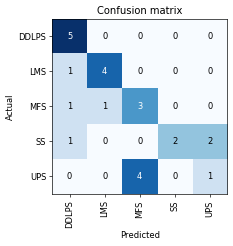

In [54]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

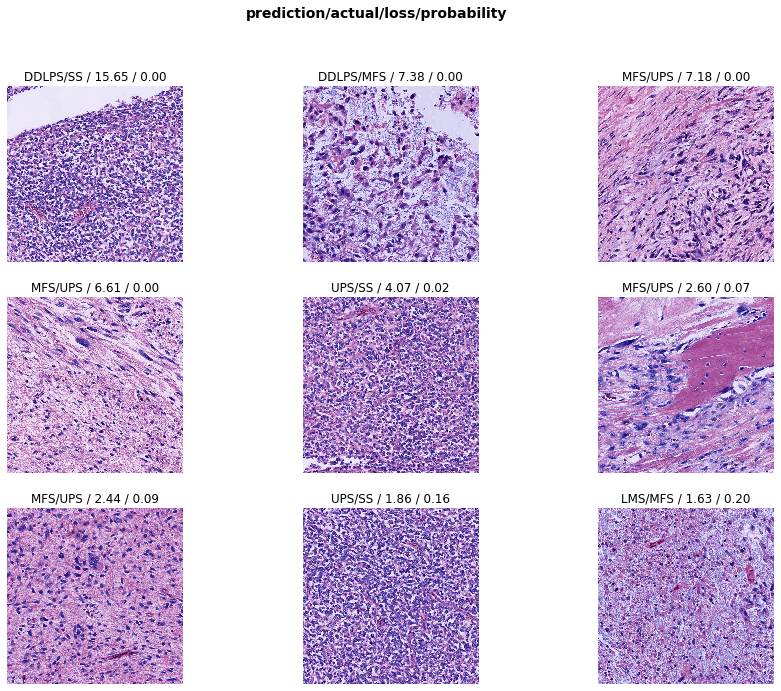

In [55]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)